# CI Final Project(for kaggle) Alireza Rashidi

## Loading Dataset:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Datasets/train2.zip /content/sample_data
!cp /content/drive/MyDrive/Datasets/CI_test.csv.zip /content/sample_data

In [ ]:
!mkdir /content/Final_Project
!unzip /content/sample_data/train2.zip -d /content/Final_Project
!unzip /content/sample_data/CI_test.csv.zip -d /content/Final_Project

Archive:  /content/sample_data/train2.zip
  inflating: /content/Final_Project/train.csv  
Archive:  /content/sample_data/CI_test.csv.zip
  inflating: /content/Final_Project/CI_test.csv  


In [ ]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
df= pd.read_csv('/content/Final_Project/train.csv', sep=',')
df.head(5)

,product_id,product_title,user_id,likes,dislikes,title,comment,advantages,disadvantages,recommend
0,90213,شارژر همراه شیاومی مدل NDY-02-AN با ظرفیت 1000...,3862150,4,1,واقعاً عالیه,سلام، قبل اینکه نظرم رو بگم میخواستم به یک موض...,"[""عمر طولانی\r"",""افت بسیار کم میزان شارژ\r"",""ا...","[""ندارد""]",recommended
1,59473,یدک پولیشر میکروفایبر مهسان مدل 20119,626843,1,0,خیلی سخت حوله اش در میاد,گیره های فلزی خیلی سخت تا میشوند و لذا حوله را...,NaN,NaN,not_recommended
2,133722,لپ تاپ 15 اینچی ایسوس مدل N501VW - A,497032,6,1,اقرار بیش از حد در ایراد گرفتن,سلام دوستان،،_x000D_\nمنم مثه بعضی از دوستان ق...,"[""همه چیز که تو مشخصات اومده بجز 3 مورد کوچیک""]","[""تاچ پدش میتونست بهتر باشه از نظر سرعت پاسخ گ...",recommended
3,148509,اسپیکر بلوتوثی دیووم مدل Bluetune bean,574130,3,0,بسیار خوب,من چند سالی هست که این اسپیکرو خریدم و واقعا ح...,"[""کیفیت ساخت بسیار خوب\r"",""کیفیت صدا بسیار عال...","[""ندارد""]",recommended
4,5107,هارددیسک اکسترنال سیگیت مدل Backup Plus Deskto...,794316,1,0,هارد با کیفیت و ظاهر شیک,نزدیک به دو ساله که این هارد رو خریدم. استفاده...,"[""کیفیت ساخت خوب\r"",""ظاهر ساده و زیبا\r"",""صدای...","[""عدم مقاومت در برابر ضربه\r"",""عدم سهولت جا به...",recommended


In [ ]:
df=df.replace(['\n'],regex=True)

## Data Preprocessing(For RNN model):

In [ ]:
print(df.shape)
# df = df.dropna()
# print(df.shape)

(48082, 10)


In [ ]:
data = df[['comment','recommend']]
data.head(10)

,comment,recommend
0,سلام، قبل اینکه نظرم رو بگم میخواستم به یک موض...,recommended
1,گیره های فلزی خیلی سخت تا میشوند و لذا حوله را...,not_recommended
2,سلام دوستان،،_x000D_\nمنم مثه بعضی از دوستان ق...,recommended
3,من چند سالی هست که این اسپیکرو خریدم و واقعا ح...,recommended
4,نزدیک به دو ساله که این هارد رو خریدم. استفاده...,recommended
5,افا از وقتی من اینو واسه پسرم خریدم همه بچه ها...,recommended
6,من این پاور بانک رو حدود یک سال پیش از دیجی کا...,recommended
7,سلام و خسته نباشید به تمامی کارکنان و بازدید ک...,not_recommended
8,بهترین روغن موتور برای موتورهای پژو همین روغنه...,recommended
9,اگر با قیمتش مشکلی ندارید نسبت به صداش شک نکنی...,recommended


In [ ]:
data = data.dropna()
print(df.isnull().values.any())
print(data.shape)

True
(48060, 2)


In [ ]:
# mapping labels to integer values
sentiment_label = data.recommend.factorize()
sentiment_label

(array([0, 1, 0, ..., 1, 0, 0]),
 Index(['recommended', 'not_recommended'], dtype='object'))

In [ ]:
# tokenize words in our dataset
pad_size = 300

data_text = data.comment.values
tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(data_text)

vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(data_text)

#The sentences have different number of words, therefore, the length of the sequence of numbers will be different. Our model requires inputs to have equal lengths, so we will have to pad the sequence to have the chosen length of inputs
padded_sequence = pad_sequences(encoded_docs, maxlen=pad_size)

In [ ]:
print('word mappings: ', tokenizer.word_index)
print('\npadded words: \n', padded_sequence)

idx = 0
print('\nactual text: ', data_text[idx])
print('encodded text: ', encoded_docs[idx])

word mappings:  {'و': 1, 'از': 2, 'که': 3, 'به': 4, 'x000d': 5, 'این': 6, 'خیلی': 7, 'من': 8, 'با': 9, 'هم': 10, 'رو': 11, 'در': 12, 'داره': 13, 'برای': 14, 'ولی': 15, 'کیفیت': 16, 'بود': 17, 'هست': 18, 'استفاده': 19, 'خریدم': 20, 'خوب': 21, 'خوبه': 22, 'اصلا': 23, 'میشه': 24, 'بسیار': 25, 'تو': 26, 'یه': 27, 'نیست': 28, 'عالی': 29, 'واقعا': 30, 'عالیه': 31, 'کردم': 32, 'تا': 33, 'یک': 34, 'های': 35, 'می': 36, 'خرید': 37, 'فقط': 38, 'پیشنهاد': 39, 'قیمت': 40, 'خوبی': 41, 'دیجی': 42, 'میکنم': 43, 'کالا': 44, 'نداره': 45, 'راضی': 46, 'نسبت': 47, 'است': 48, 'بعد': 49, 'محصول': 50, 'شده': 51, 'کار': 52, '،': 53, 'میکنه': 54, 'اما': 55, 'ها': 56, 'گوشی': 57, 'نظر': 58, 'شارژ': 59, 'روی': 60, 'قیمتش': 61, 'کنید': 62, 'را': 63, 'چون': 64, 'جنس': 65, 'کل': 66, 'ای': 67, 'باید': 68, 'دو': 69, 'اینکه': 70, 'رنگ': 71, 'بی': 72, 'دیگه': 73, 'باشه': 74, 'ارزش': 75, 'شد': 76, 'سلام': 77, 'ازش': 78, 'یا': 79, 'حتما': 80, 'هر': 81, 'گرفتم': 82, 'مناسب': 83, 'کاملا': 84, 'کنم': 85, 'همه': 86, 'توی': 87

### train_test_validation split:

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(padded_sequence, sentiment_label[0], test_size = 0.10, random_state = 42)
print("train set: ", X_train.shape, Y_train.shape)
print("test set: ", X_test.shape, Y_test.shape)

train set:  (43254, 300) (43254,)
test set:  (4806, 300) (4806,)


In [ ]:
# validation_len = int(X_test.shape[0] / 2)
# X_val = X_test[:validation_len]
# Y_val = Y_test[:validation_len]

# X_test = X_test[validation_len:]
# Y_test = Y_test[validation_len:]

# print("validation set: ", X_val.shape, Y_val.shape)
# print("test set: ", X_test.shape, Y_test.shape)

# print('\n', X_val[:5])
# print(Y_val[:5], '\n')
# print(X_test[:5])
# print(Y_test[:5])

## Creating RNN Model:

In [ ]:
embedding_vector_length = 32
batch_size = 64

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=pad_size))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))   # we have binary classification
model.compile(loss='binary_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 32)           1517152   
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,542,049
Trainable params: 1,542,049
Non-trainable params: 0
______________________________________________

In [ ]:
history = model.fit(X_train, Y_train, epochs=12, batch_size=batch_size, validation_data=(X_test, Y_test))

Epoch 1/12
676/676 [==============================] - 755s 1s/step - loss: 0.3462 - accuracy: 0.8470 - val_loss: 0.2210 - val_accuracy: 0.9130
Epoch 2/12
676/676 [==============================] - 767s 1s/step - loss: 0.2225 - accuracy: 0.9147 - val_loss: 0.2069 - val_accuracy: 0.9199
Epoch 3/12
676/676 [==============================] - 746s 1s/step - loss: 0.1992 - accuracy: 0.9253 - val_loss: 0.2107 - val_accuracy: 0.9211
Epoch 4/12
676/676 [==============================] - 747s 1s/step - loss: 0.1821 - accuracy: 0.9313 - val_loss: 0.2289 - val_accuracy: 0.9172
Epoch 5/12
676/676 [==============================] - 759s 1s/step - loss: 0.1711 - accuracy: 0.9370 - val_loss: 0.2095 - val_accuracy: 0.9209
Epoch 6/12
676/676 [==============================] - 748s 1s/step - loss: 0.1614 - accuracy: 0.9395 - val_loss: 0.2203 - val_accuracy: 0.9189
Epoch 7/12
676/676 [==============================] - 748s 1s/step - loss: 0.1545 - accuracy: 0.9426 - val_loss: 0.2295 - val_accuracy: 0.9168

In [ ]:
def learningCurve_plot(hs3, epochs3, loss, model_name):    # ploting learining curve plot for created model.
    if loss:
        plt.plot(np.arange(1, epochs3+1), hs3.history["loss"], label="train_loss")
        plt.plot(np.arange(1, epochs3+1), hs3.history["val_loss"], label="val_loss")
        plt.title(" ".join(["Learning curve loss", model_name]))
        plt.xlabel("Epoch #")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
    else:   
        plt.plot(np.arange(1, epochs3+1), hs3.history["accuracy"], label="train_acc")
        plt.plot(np.arange(1, epochs3+1), hs3.history["val_accuracy"], label="val_acc")
        plt.title(" ".join(["Learning curve accuracy", model_name]))
        plt.xlabel("Epoch #")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

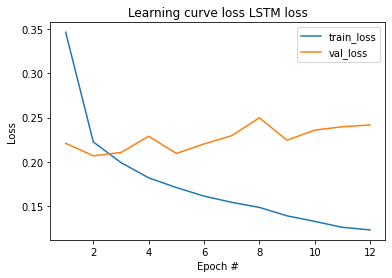

In [ ]:
learningCurve_plot(history, 12, True, "LSTM loss")

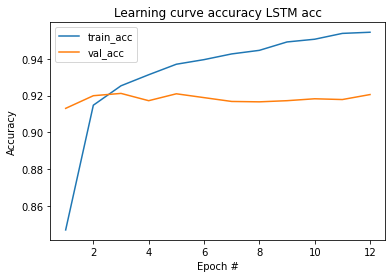

In [ ]:
learningCurve_plot(history, 12, False, "LSTM acc")

## Prediction using test set:

In [ ]:
scores = model.evaluate(X_test, Y_test, verbose=1)
print('Test accuracy:', scores[1])
print('Test loss:', scores[0])

151/151 [==============================] - 12s 77ms/step - loss: 0.2416 - accuracy: 0.9205
Test accuracy: 0.9205160140991211
Test loss: 0.2416422963142395


### here we test some text input for verifying our models functionalty:

In [31]:
# using some test word for prediction...

test_word = 'خوب هست'
tw = tokenizer.texts_to_sequences([test_word])
tw = pad_sequences(tw, maxlen=pad_size)

prediction = int(model.predict(tw).round().item())
print("predicted result is: ", sentiment_label[1][prediction])

predicted result is:  recommended


## Using test data:

In [32]:
df_test = pd.read_csv('/content/Final_Project/CI_test.csv', sep=',')
df_test.head(10)

,id,product_id,product_title,user_id,likes,dislikes,title,comment,advantages,disadvantages
0,1,146879,فلاسک غذا خودرو بلک اند دکر مدل BDV212F,2838703,15,12,فقط مناسب سفر طولانی,با توجه به قدرت خنک کنندگی حداقل ۲ ساعت زمان ل...,NaN,NaN
1,2,120648,ادو تویلت مردانه آنتونیو باندراس مدل The Golde...,1307120,5,3,خوش بو,بسیار خوش بو ولی ماندگاری در حد یک ساعت ، با ا...,NaN,NaN
2,3,76932,محلول تقویت و رشد ابرو لامینین 12ml,2724686,8,3,بدون فایده,اصلا تأثیری نداشت,NaN,NaN
3,4,179072,فن هیتر فلر مدل HFC201,2499534,5,0,NaN,کیفیت بدنه خیلی خوبی داره._x000D_\nوقتی در جای...,NaN,NaN
4,5,184047,گوشی موبایل آنر مدل 6X BLN-L21 دو سیم‌ کارت,906159,19,4,فوق العاده در یک کلام,دو ساله استفاده میکنم، واقعاً هیچ کجا برام کم ...,"[""حسگر فوق‌العاده اثرانگشت \r"",""قابلیت تنظیم ف...",NaN
5,6,78098,کرم مرطوب کننده پوست خشک و معمولی سینره حجم 65...,3124361,2,0,کیفیت عالی,خیلی کرم خوب و با کیفیت من همیشه همین کرم را م...,NaN,NaN
6,7,90894,مچ‌ بند هوشمند آی واون مدل i5 Plus,2937957,10,0,نبود بند یدک,برای یکساله داره کار می‌کنه و مشکل ندارد \nفقط...,[],[]
7,8,34191,ماوس بی‌سیم گرین مدل GM-501W,2491416,2,3,مصرف زیاد باتری,من 6 ماهه اینو از دیجی گرفتم تقریبا بعد حدود ی...,NaN,"[""مصرف زیاد باتری""]"
8,9,158804,مانیتور بنکیو مدل GW2470H سایز 23.8 اینچ,573626,3,0,شگفت انگیز!,من خودم این مانیتور رو برای گیم و ترجمه گرفتم،...,"[""غلظت رنگ بالا\r"",""زاویه دید خوب\r"",""کانترست ...","[""کمی پایین بودن سرعت ریفرش پیکسل های مشکی\r"",..."
9,10,163465,آون توستر متئو مدل EO099,1126039,8,0,عالییه,از هر لحاظ بی نظیر و عالیه. از خریدتون پشیمون ...,NaN,"[""ندارد""]"


In [33]:
print(df_test['comment'].isnull().sum())
df_test['comment'] = df_test['comment'].fillna('خوب', inplace=False)
print(df_test['comment'].shape)

2
(5000,)


In [34]:
df_test['comment']

0       با توجه به قدرت خنک کنندگی حداقل ۲ ساعت زمان ل...
1       بسیار خوش بو ولی ماندگاری در حد یک ساعت ، با ا...
2                                       اصلا تأثیری نداشت
3       کیفیت بدنه خیلی خوبی داره._x000D_\nوقتی در جای...
4       دو ساله استفاده میکنم، واقعاً هیچ کجا برام کم ...
                              ...                        
4995    من از دی جی کالا خریدم خیلی عالیه._x000D_\nپیش...
4996        خیلی خوبه._x000D_\nاندازه هاش کاربردی و عالیه
4997    چرب کردن مو باعث جلوگیری از سفیدی زودرس و پیری...
4998                 بعداز  یک ماه زرد میشه از هم در میره
4999    من با قیمت ارزون خریدم. ولی کیفیت و کارایی و د...
Name: comment, Length: 5000, dtype: object

In [35]:
data_test = df_test[['comment']]
# data_test = data_test.dropna()

data_text = data_test.comment.values
tw = tokenizer.texts_to_sequences(data_text)
tw = pad_sequences(tw, maxlen=pad_size)
tw

array([[   0,    0,    0, ...,  212,  613,   96],
       [   0,    0,    0, ..., 2594,   75,   45],
       [   0,    0,    0, ...,    0,   23,  258],
       ...,
       [   0,    0,    0, ...,   41,  817,  417],
       [   0,    0,    0, ...,   10,   12,  498],
       [   0,    0,    0, ...,  264,    1, 2252]], dtype=int32)

In [ ]:
prediction_results = model.predict(tw)
prediction_results

array([[0.00636425],
       [0.96408594],
       [0.9703809 ],
       ...,
       [0.1347451 ],
       [0.96522   ],
       [0.38967276]], dtype=float32)

In [ ]:
prediction_results = np.round(prediction_results).astype(int)
prediction_results_labels = sentiment_label[1][prediction_results]
ids = np.array(list(range(1, prediction_results_labels.shape[0]+1))).reshape(-1,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


In [ ]:
mixed = np.concatenate((ids, prediction_results_labels), axis=1)
column_values = ['id', 'recommend']
pd.DataFrame(data = mixed, columns = column_values).to_csv('test_result.csv', header=True, index=False)

## Saving model and it's parammeters:

In [ ]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
model.save_weights('my_model_weights.h5', overwrite=True)

## Loading model:

In [ ]:
# model = load_model('my_model.h5')